In [1]:
#import data manipulation libraries
import pandas as pd
import numpy as np

#import data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import filter warning libraries
import warnings
warnings.filterwarnings('ignore')

#Import loggings
import logging
logging.basicConfig(level = logging.INFO,
                    format = '%(asctime)s - %(levelname)s - %(message)s',
                    filemode = 'w',
                    filename = 'model.log', force = True)

#Import Sci-kit Learn Libraries for model building
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
url = 'https://raw.githubusercontent.com/anirudhakolay/Bank_Telemarketing_Classifier/refs/heads/main/bank.csv'
df = pd.read_csv(url, sep = ';')
df.sample(frac=1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4076,53,blue-collar,married,primary,no,53,yes,no,cellular,7,apr,208,1,140,1,failure,no
4059,42,technician,divorced,secondary,no,1533,no,yes,cellular,5,aug,86,1,-1,0,unknown,no
2655,42,technician,married,secondary,no,4945,yes,no,cellular,2,mar,311,2,-1,0,unknown,yes
2779,52,management,married,secondary,no,-588,yes,no,cellular,22,jul,81,4,-1,0,unknown,no
2074,53,technician,married,secondary,no,230,no,yes,cellular,13,aug,112,2,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485,53,blue-collar,married,primary,no,238,yes,no,cellular,11,may,238,2,361,5,failure,no
2562,46,admin.,divorced,secondary,no,7378,no,no,cellular,18,nov,466,1,-1,0,unknown,no
3713,32,blue-collar,married,secondary,no,119,no,no,cellular,4,may,20,5,-1,0,unknown,no
3804,40,admin.,single,secondary,no,1670,yes,no,unknown,18,jun,161,2,-1,0,unknown,no


In [3]:
#Dataset information
df.info() #no of col*20(min rows data to train model)=20*17

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [4]:
#Evaluate Descriptive stats: EDA

# Step 1: Sagregate Categorical columns nd Numerical
categorical_col = df.select_dtypes(include = 'object')
numerical_col = df.select_dtypes(include = ['int64','float64']) #or exclude = 'object'


In [5]:
#Step 2: Evaluate Descriptive Stats
#Logistic model works onSigmoid function
#Univariate Analysis
'''
Step 2.1 : Create a blank list : stats = []
Step 2.2 : Using OrderedDict create dictionary
Step 2.3 : Append the list : stats[]
Step 2.4 : DataFrame
'''
from collections import OrderedDict

stats = []

for i in numerical_col.columns:
    numerical_stats = OrderedDict({
        'Feature' : i,
        'Mean' : df[i].mean(),
        'Median' : df[i].median(),
        'Mode' : df[i].mode()[0],
        'Minimum' : df[i].min(),
        'Maximum' : df[i].max(),
        'Q1' : df[i].quantile(0.25),
        'Q3' : df[i].quantile(0.75),
        'IQR' : df[i].quantile(0.75) - df[i].quantile(0.25), #IQR cannot be 0
        'Std' : df[i].std(),
        'skewness' : df[i].skew(), #positive skewness (right skew), negative skewness (left skew), and zero skewness (symmetrical distribution, i.e. normal data)
        'kurtosis' : df[i].kurtosis(), # mesokurtic, leptokurtic, and platykurtic.
        'Variance' : df[i].var(),
        'Standard Deviation' : df[i].std() #spread of data, under root variance
        
    })
    stats.append(numerical_stats)
    report = pd.DataFrame(stats)
report

#WHen evaluating Descriptive analysis IQR of any col cannot be 0, the col will not contribute in ML model performance

,Feature,Mean,Median,Mode,Minimum,Maximum,Q1,Q3,IQR,Std,skewness,kurtosis,Variance,Standard Deviation
0,age,41.170095,39.0,34,19,87,33.0,49.0,16.0,10.576211,0.699501,0.348775,1.118562e+02,10.576211
1,balance,1422.657819,444.0,0,-3313,71188,69.0,1480.0,1411.0,3009.638142,6.596431,88.390332,9.057922e+06,3009.638142
2,day,15.915284,16.0,20,1,31,9.0,21.0,12.0,8.247667,0.094627,-1.039531,6.802402e+01,8.247667
3,duration,263.961292,185.0,123,4,3025,104.0,329.0,225.0,259.856633,2.772420,12.530050,6.752547e+04,259.856633
4,campaign,2.793630,2.0,1,1,50,1.0,3.0,2.0,3.109807,4.743914,37.168920,9.670897e+00,3.109807
5,pdays,39.766645,-1.0,-1,-1,871,-1.0,-1.0,0.0,100.121124,2.717071,7.957128,1.002424e+04,100.121124
6,previous,0.542579,0.0,0,0,25,0.0,0.0,0.0,1.693562,5.875259,51.995212,2.868153e+00,1.693562


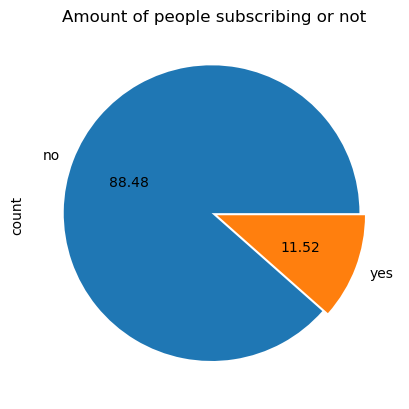

In [6]:
#Problem Defination:
'''
The dataset consist of 4521 rows and 17 columns, This dataset belongs to Portugal bank where our aim is to classify whether the customer will subscribe the band term deposit or not.

Type of ML model: Binary Classification

Above dataset is a type of Multivariate Analysis

X: Independent Columns
y: Target Column/Dependent Columns

Here y, acts as Target Col/Dependent Column.
'''

#Checking the distribution of people who subscribe the term deposit
'''
Based on distribution of target column(y), we found that the data is imbalance.
'''

df['y'].value_counts().plot(kind = 'pie', autopct = '%1.2f', explode = [0.02,0.02])
plt.title("Amount of people subscribing or not")
plt.show()

In [7]:
# Data Insights

'''
1. 88.48% people are not susbscribing bank term deposit.
2. Only 11.52% people are subscribing bamk terms.
3. The Average call duration recorded 264 seconds. This can be one of the cause for people who have not subscribed the bank term deposit.
df['duration'].mean()- 263.9
4. If the call duration more than 300 seconds the chances are there that person will subscribe bank term deposit.
5. The Target audience is Divorsed people.
6. The people excluded who had taken a loan are excluded from the bank term deposit subscription.
7. The people have housing loan havn't subscribed.

'''

"\n1. 88.48% people are not susbscribing bank term deposit.\n2. Only 11.52% people are subscribing bamk terms.\n3. The Average call duration recorded 264 seconds. This can be one of the cause for people who have not subscribed the bank term deposit.\ndf['duration'].mean()- 263.9\n4. If the call duration more than 300 seconds the chances are there that person will subscribe bank term deposit.\n5. The Target audience is Divorsed people.\n6. The people excluded who had taken a loan are excluded from the bank term deposit subscription.\n7. The people have housing loan havn't subscribed.\n\n"

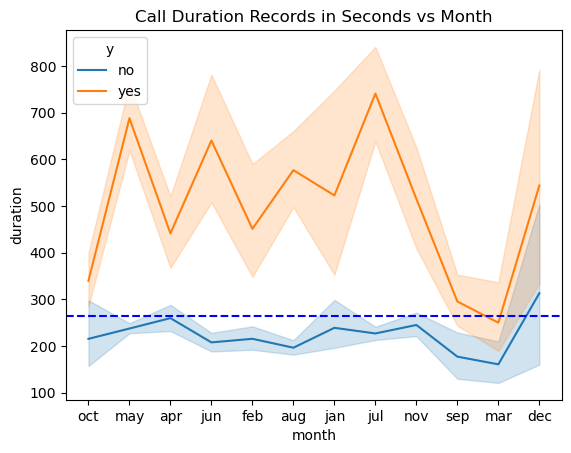

In [8]:
sns.lineplot(x = df['month'],y = df['duration'], hue = df['y'])
plt.axhline(df['duration'].mean(), linestyle = "--", c = 'b') #avg duration
plt.title('Call Duration Records in Seconds vs Month')
plt.show()

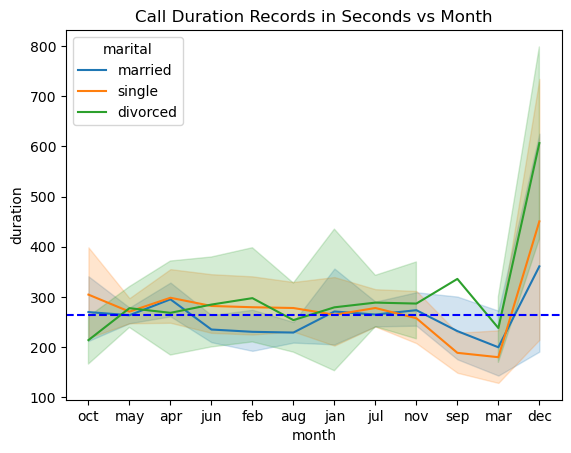

In [9]:
sns.lineplot(x = df['month'],y = df['duration'], hue = df['marital'])
plt.axhline(df['duration'].mean(), linestyle = "--", c = 'b') #avg duration
plt.title('Call Duration Records in Seconds vs Month')
plt.show()


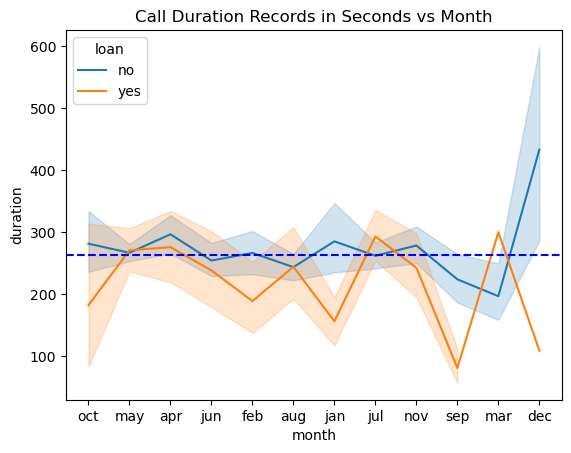

In [10]:
#Bivariate Analysis
sns.lineplot(x = df['month'],y = df['duration'], hue = df['loan'])
plt.axhline(df['duration'].mean(), linestyle = "--", c = 'b') #avg duration
plt.title('Call Duration Records in Seconds vs Month')
plt.show()

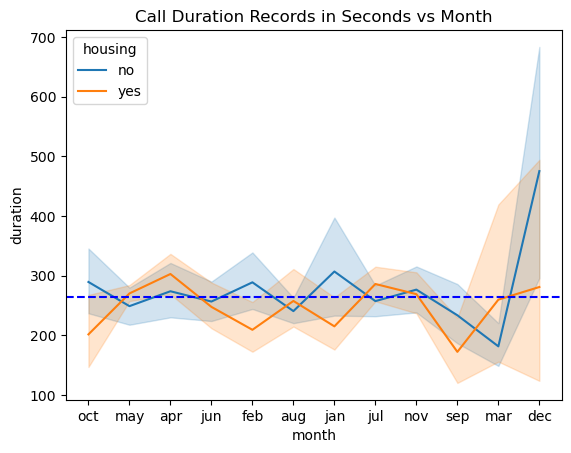

In [11]:
#Bivariate Analysis
sns.lineplot(x = df['month'],y = df['duration'], hue = df['housing'])
plt.axhline(df['duration'].mean(), linestyle = "--", c = 'b') #avg duration
plt.title('Call Duration Records in Seconds vs Month')
plt.show()

<Axes: ylabel='count'>

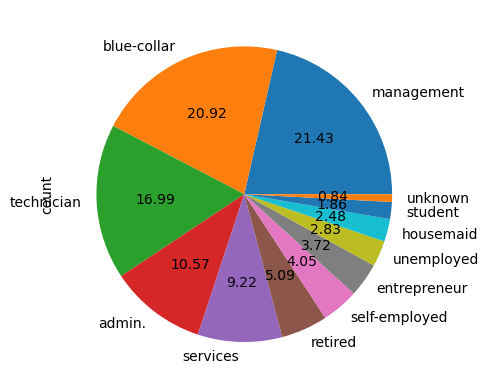

In [12]:
df['job'].value_counts().plot(kind = 'pie', autopct = '%1.2f')

In [13]:
df['job'] == 'management'

0       False
1       False
2        True
3        True
4       False
        ...  
4516    False
4517    False
4518    False
4519    False
4520    False
Name: job, Length: 4521, dtype: bool

In [14]:
management = df[df['job'] == 'management']

In [15]:
bluecollar = df[df['job'] == 'blue-collar']

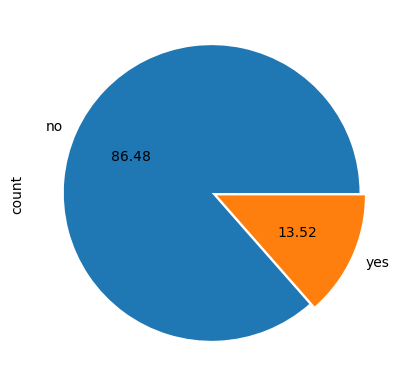

In [16]:
#Management people who have highest salary doesn't subscribe
management['y'].value_counts().plot(kind = 'pie', autopct = '%1.2f', explode = [0.02,0.02])
plt.show()

<Axes: ylabel='balance'>

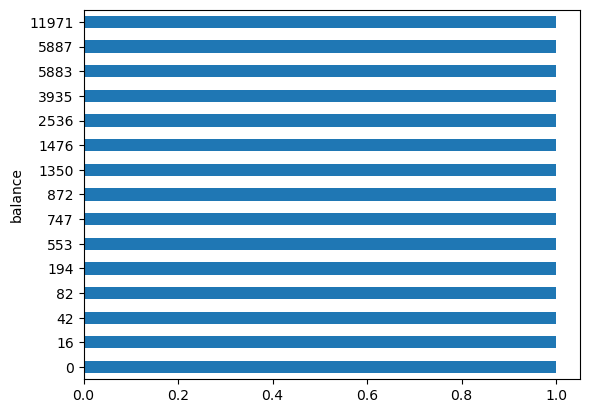

In [17]:
#Top 15 people with highest balance in management in ascending order
management['balance'][:15].sort_values(ascending = True).value_counts().plot(kind = 'barh')

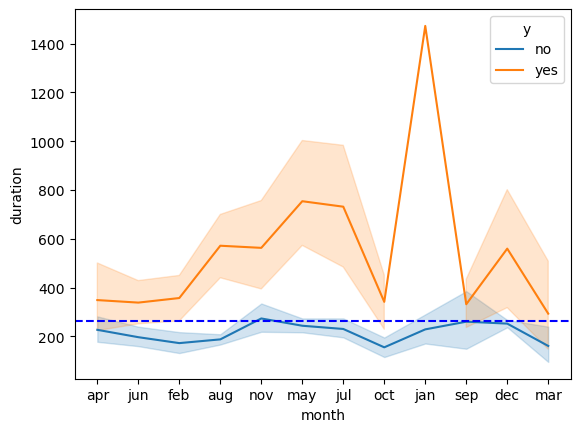

In [18]:
sns.lineplot(x = management['month'], y = management['duration'], hue = management['y'])
plt.axhline(264, linestyle = '--', c = 'b')
plt.show()

In [19]:
technician = df[df['job'] == 'technician']

In [20]:
admin = df[df['job'] == 'admin.']

In [21]:
bluecollar

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
14,31,blue-collar,married,secondary,no,360,yes,yes,cellular,29,jan,89,1,241,1,failure,no
18,25,blue-collar,single,primary,no,-221,yes,no,unknown,23,may,250,1,-1,0,unknown,no
26,55,blue-collar,married,primary,no,627,yes,no,unknown,5,may,247,1,-1,0,unknown,no
37,32,blue-collar,married,secondary,no,2089,yes,no,cellular,14,nov,132,1,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4511,46,blue-collar,married,secondary,no,668,yes,no,unknown,15,may,1263,2,-1,0,unknown,yes
4512,40,blue-collar,married,secondary,no,1100,yes,no,unknown,29,may,660,2,-1,0,unknown,no
4513,49,blue-collar,married,secondary,no,322,no,no,cellular,14,aug,356,2,-1,0,unknown,no
4514,38,blue-collar,married,secondary,no,1205,yes,no,cellular,20,apr,45,4,153,1,failure,no


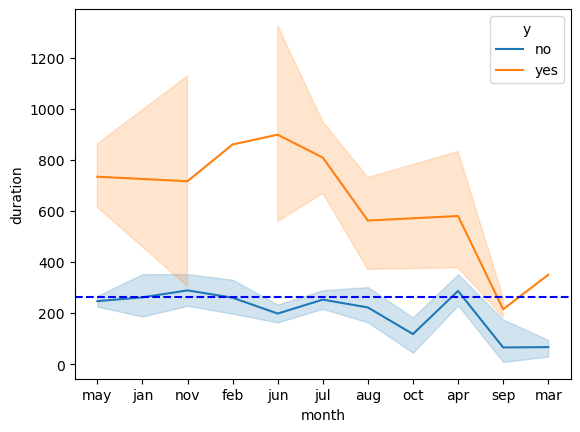

In [22]:
sns.lineplot(x = bluecollar['month'], y = bluecollar['duration'], hue = bluecollar['y'])
plt.axhline(264, linestyle = '--', c = 'b')
plt.show()

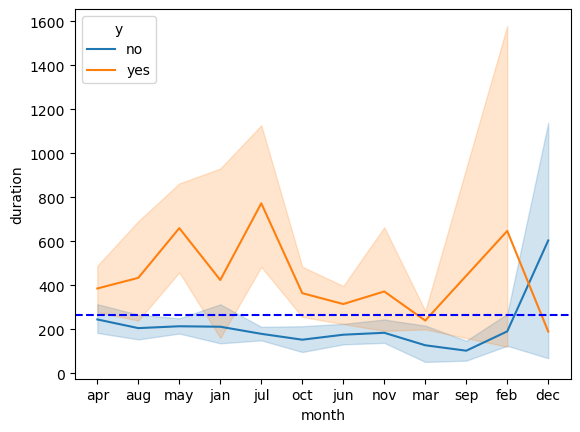

In [23]:
sns.lineplot(x = admin['month'], y = admin['duration'], hue = admin['y'])
plt.axhline(264, linestyle = '--', c = 'b')
plt.show()

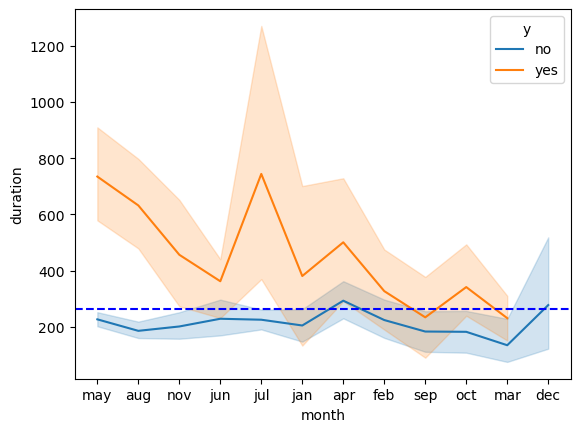

In [24]:
sns.lineplot(x = technician['month'], y = technician['duration'], hue = technician['y'])
plt.axhline(264, linestyle = '--', c = 'b')
plt.show()

In [25]:
admin

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
11,43,admin.,married,secondary,no,264,yes,no,cellular,17,apr,113,2,-1,0,unknown,no
17,37,admin.,single,tertiary,no,2317,yes,no,cellular,20,apr,114,1,152,2,failure,no
29,53,admin.,married,secondary,no,105,no,yes,cellular,21,aug,74,2,-1,0,unknown,no
35,42,admin.,divorced,secondary,no,1811,yes,no,unknown,14,may,150,1,-1,0,unknown,no
49,61,admin.,married,unknown,no,4629,yes,no,cellular,27,jan,181,1,92,1,success,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4482,46,admin.,married,secondary,no,466,yes,no,cellular,29,jan,169,1,-1,0,unknown,no
4490,58,admin.,married,secondary,no,3496,yes,no,unknown,2,jun,111,4,-1,0,unknown,no
4500,38,admin.,married,secondary,no,4196,yes,no,cellular,12,may,193,2,-1,0,unknown,no
4505,32,admin.,single,secondary,no,620,yes,no,unknown,26,may,1234,3,-1,0,unknown,yes


In [26]:
numerical_col

,age,balance,day,duration,campaign,pdays,previous
0,30,1787,19,79,1,-1,0
1,33,4789,11,220,1,339,4
2,35,1350,16,185,1,330,1
3,30,1476,3,199,4,-1,0
4,59,0,5,226,1,-1,0
...,...,...,...,...,...,...,...
4516,33,-333,30,329,5,-1,0
4517,57,-3313,9,153,1,-1,0
4518,57,295,19,151,11,-1,0
4519,28,1137,6,129,4,211,3


In [27]:
'''

1. pdays and previous these 2 cols shows IQR = 0, Hence we need to drop them.
2. Target column must be decoded separately either by using replace function or map function.
'''
#Create a copy of df
data = df.copy()
data.sample(frac = 1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3346,55,admin.,married,secondary,no,865,yes,no,cellular,27,oct,96,1,111,3,failure,no
4399,29,entrepreneur,married,secondary,no,452,yes,no,unknown,27,may,347,1,-1,0,unknown,no
2982,38,technician,married,tertiary,no,1161,yes,no,unknown,8,may,665,1,-1,0,unknown,no
3387,52,technician,single,tertiary,no,1308,yes,no,unknown,29,may,361,1,-1,0,unknown,no
3093,53,entrepreneur,married,tertiary,no,71,no,yes,cellular,29,jan,86,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,30,blue-collar,single,secondary,no,648,yes,yes,unknown,8,may,287,1,-1,0,unknown,no
3028,34,admin.,married,secondary,no,79,yes,no,unknown,23,may,83,1,-1,0,unknown,no
2527,36,services,single,secondary,no,398,yes,yes,unknown,17,jun,77,2,-1,0,unknown,no
737,36,technician,married,secondary,no,480,no,no,cellular,20,oct,213,1,-1,0,unknown,yes


In [28]:
#Encoding using get_dummies method
'''
Observation:
1. The no. of columns are increased, which impact badly wrt Model Building
'''
data = pd.get_dummies(data, drop_first = True, dtype = 'int')

In [29]:
data

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,30,1787,19,79,1,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,33,4789,11,220,1,339,4,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,35,1350,16,185,1,330,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,1476,3,199,4,-1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,59,0,5,226,1,-1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,-333,30,329,5,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4517,57,-3313,9,153,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4518,57,295,19,151,11,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4519,28,1137,6,129,4,211,3,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [30]:
# Encoding Technique : Label Encoder

preprocess_data = df.copy()
# preprocess_data

from sklearn.preprocessing import LabelEncoder

le  = LabelEncoder()

#Transform all categorical columns : Independent Columns
df['job'] = le.fit_transform(df['job'])
df['marital'] = le.fit_transform(df['marital'])
df['education'] = le.fit_transform(df['education'])
df['default'] = le.fit_transform(df['default'])
df['housing'] = le.fit_transform(df['housing'])
df['loan'] = le.fit_transform(df['loan'])
df['contact'] = le.fit_transform(df['contact'])
df['month'] = le.fit_transform(df['month'])
df['poutcome'] = le.fit_transform(df['poutcome'])

#Transform Target column to Numerical
df['y'] = df['y'].replace({'yes' : 1, 'no' : 0})

In [31]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,7,1,1,0,-333,1,0,0,30,5,329,5,-1,0,3,0
4517,57,6,1,2,1,-3313,1,1,2,9,8,153,1,-1,0,3,0
4518,57,9,1,1,0,295,0,0,0,19,1,151,11,-1,0,3,0
4519,28,1,1,1,0,1137,0,0,0,6,3,129,4,211,3,1,0


In [32]:
#Concept  of Data Leakage
'''

Step 1: Split the dataset into X and y.
        X : Independent Columns
        y : Target Columns

Step 2: Split the data into train and test
        train data: Seen Data
        test data: Unseen Data

Step 3: Try Balance the **target** column in case of classification problem
        Imbalance Technique : 1. Oversampling 2. Undersampling

Step 4: Use Scaling Technique:
        1. MinMaxScaler(Non Normal)
        2. RobustScaler(sensitive outlier)
        3. StandardScaler(Normal)
If overfits:
-- robust
-- outlier
-- variance
-- Data leakage

Step 5: Model Building

'''

# Step 1: Split the Dataset into X and y

X = df.drop(columns = ['pdays', 'previous','y'], axis = 1)
y = df['y']

# Step 2: Split the Dataset into Train and Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42) 

# Step 3: Balancing the Target Column
#Check with all SMOTE, ADASYN, SMOTEN and others
#Use Oversampling not undersampling as it will affect modeling
#UnderSample will reducce sample size, underfit
#OverSample can cover more data points
from imblearn.over_sampling import SMOTE,ADASYN,SMOTENC
from imblearn.under_sampling import AllKNN,ClusterCentroids

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train) #we do sampling on training data
y_train.value_counts() # 1= 2795,0= 2795


# Step 4: Scaling Techniques

sc = RobustScaler() #will give best, standard will also be good as it is now balanced, but robust gives more
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [33]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

# Check class distribution after resampling
print(y_train.value_counts())  # e.g., 1=2795, 0=2795


y
0    2795
1    2795
Name: count, dtype: int64


In [34]:
from imblearn.over_sampling import SMOTEN

# Apply SMOTEN (only if features are categorical)
smoten = SMOTEN(random_state=42)
X_train, y_train = smoten.fit_resample(X_train, y_train)

# Check class distribution after resampling
print(y_train.value_counts())  # e.g., 1=2795, 0=2795




y
0    2795
1    2795
Name: count, dtype: int64


In [35]:
from imblearn.under_sampling import ClusterCentroids,AllKNN

# Apply ClusterCentroids
cc = ClusterCentroids(random_state=42)
X_train, y_train = cc.fit_resample(X_train, y_train)

# Check class distribution after resampling
print(y_train.value_counts()) 

y
0    2795
1    2795
Name: count, dtype: int64


In [36]:
from imblearn.over_sampling import KMeansSMOTE
# Apply KMeansSMOTE
kmeans_smote = KMeansSMOTE(random_state=42)
X_train, y_train = kmeans_smote.fit_resample(X_train, y_train)

# Check class distribution after resampling
print(y_train.value_counts())  

y
0    2795
1    2795
Name: count, dtype: int64


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

RF = RandomForestClassifier().fit(X_train,y_train)
y_pred_RF = RF.predict(X_test)

print('The Model Accuracy for the Random Forest Classifier: ',accuracy_score(y_test,y_pred_RF))

The Model Accuracy for the Random Forest Classifier:  0.8754605747973471


In [38]:
from sklearn.ensemble import GradientBoostingClassifier

gbr = GradientBoostingClassifier().fit(X_train,y_train)
y_pred_gbr = gbr.predict(X_test)

print('Model Accuracy for Gradient Boosting Classifier:',accuracy_score(y_test,y_pred_gbr))

Model Accuracy for Gradient Boosting Classifier: 0.8570375829034635


In [39]:
# Logistic Regression
'''
Classification problem:
    1. Binary Classification : Sigmoid function
    2. Multiclass Classification : Softmax classifcation
'''

from sklearn.linear_model import LogisticRegression

LR = LogisticRegression().fit(X_train,y_train)
y_pred_LR = LR.predict(X_test)

print(f'The Accuracy score for Logistic Regression',accuracy_score(y_test,y_pred_LR))

The Accuracy score for Logistic Regression 0.823876197494473


The Accuracy score for Decision tree 0.8319823139277819


<Axes: xlabel='y'>

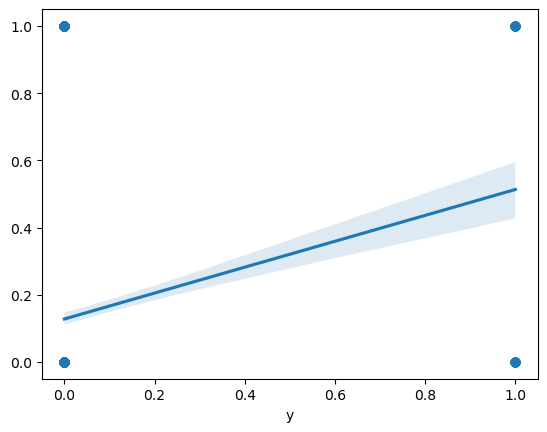

In [40]:
# Tree Based Algorithm

from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier().fit(X_train,y_train)
y_pred_DT = DT.predict(X_test)

print(f'The Accuracy score for Decision tree',accuracy_score(y_test,y_pred_DT))

#Model Performance
sns.regplot(x = y_test, y =y_pred_DT)

<Axes: xlabel='y', ylabel='Density'>

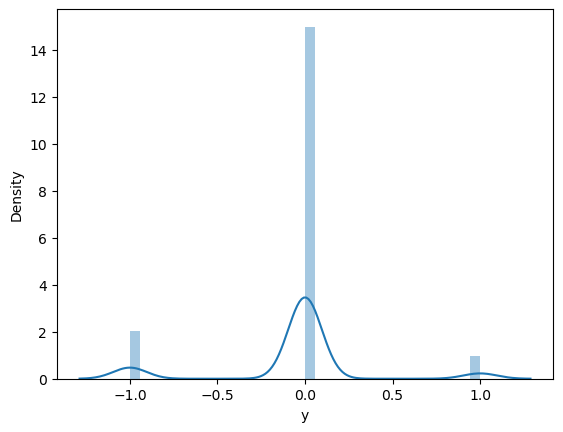

In [41]:
sns.distplot(y_test-y_pred_DT)

In [42]:
from sklearn.svm import SVC

SVM = SVC(random_state = 42).fit(X_train, y_train)
y_pred_SVM = SVM.predict(X_test)

print(f'The Accuracy score for SVM:', accuracy_score(y_test, y_pred_SVM))


The Accuracy score for SVM: 0.8511422254974208


In [43]:
from xgboost import XGBClassifier

XGB = XGBClassifier(random_state = 42).fit(X_train, y_train)
y_pred_XGB = XGB.predict(X_test)

print(f'The Accuracy score for XGBoost:', accuracy_score(y_test, y_pred_XGB))


The Accuracy score for XGBoost: 0.8784082535003684


In [44]:
from sklearn.linear_model import SGDClassifier

SGD = SGDClassifier(random_state = 42).fit(X_train, y_train)
y_pred_SGD = SGD.predict(X_test)

print(f'The Accuracy score for SGD Classifier:', accuracy_score(y_test, y_pred_SGD))


The Accuracy score for SGD Classifier: 0.817243920412675


In [45]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier().fit(X_train, y_train)
y_pred_KNN = KNN.predict(X_test)

print(f'The Accuracy score for KNN:', accuracy_score(y_test, y_pred_KNN))


The Accuracy score for KNN: 0.8282977155490051


In [46]:
from sklearn.cluster import KMeans

KMEANS = KMeans(n_clusters=3, random_state=42).fit(X_train)
y_pred_KMEANS = KMEANS.predict(X_test)

print(f'The cluster assignments for K-Means:', accuracy_score(y_test,y_pred_KMEANS))

The cluster assignments for K-Means: 0.45689019896831246
